In [1]:
import pandas as pd
import numpy as np


import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
import os
from tqdm.notebook import tqdm
import gc
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns; sns.set()
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [2]:
TARGET_COL = "diabetes_mellitus"
df = pd.read_csv("../input/widsdatathon2021/TrainingWiDS2021.csv")
print(df.shape)
test = pd.read_csv("../input/widsdatathon2021/UnlabeledWiDS2021.csv")
print(test.shape)
df['label']='train'
test['label']='test'
frames = [df,test]
join_df = pd.concat(frames, keys=['x', 'y'])
assert len(join_df) == len(df) + len(test)
lst = join_df.isna().sum()/len(join_df)
p = pd.DataFrame(lst)
p.reset_index(inplace=True)
p.columns = ['a','b']
low_count = p[p['b']>0.8]
todelete=low_count['a'].values
join_df.drop(todelete,axis=1,inplace=True)
join_df.head()

(130157, 181)
(10234, 180)


Unnamed: 0  encounter_id  hospital_id   age        bmi  elective_surgery  \
x 0           1        214826          118  68.0  22.732803                 0   
  1           2        246060           81  77.0  27.421875                 0   
  2           3        276985          118  25.0  31.952749                 0   
  3           4        262220          118  81.0  22.635548                 1   
  4           5        201746           33  19.0        NaN                 0   

     ethnicity gender  height hospital_admit_source  ... d1_pao2fio2ratio_min  \
x 0  Caucasian      M   180.3                 Floor  ...                  NaN   
  1  Caucasian      F   160.0                 Floor  ...            51.000000   
  2  Caucasian      F   172.7  Emergency Department  ...                  NaN   
  3  Caucasian      F   165.1        Operating Room  ...           236.666667   
  4  Caucasian      M   188.0                   NaN  ...                  NaN   

     aids cirrhosis hepatic_failure  immunosuppression  leukemia  lymphoma  \
x 0     0         0               0                  0         0         0   
  1     0         0               0                  0         0         0   
  2     0         0               0                  0         0         0   
  3     0         0               0                  0         0         0   
  4     0         0               0                  0         0         0   

     solid_tumor_with_metastasis  diabetes_mellitus  label  
x 0                            0                1.0  train  
  1                            0                1.0  train  
  2                            0                0.0  train  
  3                            0                0.0  train  
  4                            0                0.0  train  

[5 rows x 150 columns]

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
join_df.drop(['Unnamed: 0','encounter_id'],inplace=True,axis=1)
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = join_df.select_dtypes(include=numerics)
numeric_cols = newdf.columns

# Need to do column by column due to memory constraints
categorical_cols =  ['elective_surgery','hospital_id','icu_id',
 'ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type','aids','cirrhosis','hepatic_failure','immunosuppression',
 'leukemia','lymphoma','solid_tumor_with_metastasis','elective_surgery','apache_post_operative','arf_apache','fio2_apache','gcs_unable_apache','gcs_eyes_apache',
 'gcs_motor_apache','gcs_verbal_apache','intubated_apache','ventilated_apache','solid_tumor_with_metastasis']
for i, v in tqdm(enumerate(categorical_cols)):
    join_df[v] = join_df[v].fillna(join_df[v].value_counts().index[0])
for i, v in tqdm(enumerate([numeric_cols])):
    join_df[v] =join_df.groupby(['ethnicity','gender'], sort=False)[v].apply(lambda x: x.fillna(x.mean()))
join_df[categorical_cols].isna().sum()

elective_surgery               0
hospital_id                    0
icu_id                         0
ethnicity                      0
gender                         0
hospital_admit_source          0
icu_admit_source               0
icu_stay_type                  0
icu_type                       0
aids                           0
cirrhosis                      0
hepatic_failure                0
immunosuppression              0
leukemia                       0
lymphoma                       0
solid_tumor_with_metastasis    0
elective_surgery               0
apache_post_operative          0
arf_apache                     0
fio2_apache                    0
gcs_unable_apache              0
gcs_eyes_apache                0
gcs_motor_apache               0
gcs_verbal_apache              0
intubated_apache               0
ventilated_apache              0
solid_tumor_with_metastasis    0
dtype: int64

In [5]:
from sklearn.preprocessing import OrdinalEncoder

# In loop to minimize memory use
for i, v in tqdm(enumerate(categorical_cols)):
    join_df[v] = OrdinalEncoder(dtype="int").fit_transform(join_df[[v]])
    

gc.collect()

train = join_df[join_df['label']=="train"]
predict = join_df[join_df['label']=='test']

train.reset_index(inplace=True)
train.drop(['level_0','level_1','label'],inplace=True,axis =1 )

predict.reset_index(inplace=True)
predict.drop(['level_0','level_1','diabetes_mellitus','label'],inplace=True,axis=1)
features = train.columns
num_feature = [col for col in features if col not in categorical_cols]

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
num_feature = [col for col in features if col not in categorical_cols and train[col].dtype != 'object']
drop_columns=[]
corr = train[num_feature].corr()
# Drop highly correlated features 
columns = np.full((corr.shape[0],), True, dtype=bool)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >=0.999 :
            if columns[j]:
                columns[j] = False
                print('FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(train[num_feature].columns[i] , train[num_feature].columns[j], corr.iloc[i,j]))
        elif corr.iloc[i,j] <= -0.995:
            if columns[j]:
                columns[j] = False

FEAT_A: paco2_apache FEAT_B: paco2_for_ph_apache - Correlation: 1.0
FEAT_A: d1_inr_max FEAT_B: h1_inr_max - Correlation: 1.0
FEAT_A: d1_inr_min FEAT_B: h1_inr_min - Correlation: 1.0


In [7]:
drop_columns = train[num_feature].columns[columns == False].values
print('drop_columns',len(drop_columns),drop_columns)

drop_columns 3 ['paco2_for_ph_apache' 'h1_inr_max' 'h1_inr_min']


In [8]:
train.drop(drop_columns,inplace=True,axis =1 )
predict.drop(drop_columns,inplace=True,axis =1 )
train[TARGET_COL].value_counts()/len(train)

0.0    0.783715
1.0    0.216285
Name: diabetes_mellitus, dtype: float64

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
df_majority = train[train['diabetes_mellitus']==0]
df_minority = train[train['diabetes_mellitus']==1]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=83798,    # to match majority class
                                 random_state= 303) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.diabetes_mellitus.value_counts()
train = df_upsampled

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
     train[[c for c in train if TARGET_COL != c]], train[TARGET_COL], test_size=0.20, random_state=42)
print(X_train.shape,X_test.shape)

(148643, 143) (37161, 143)


In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [12]:
optuna=False

In [13]:
import optuna.integration.lightgbm as lgb
if optuna:
# old prams
    params={'learning_rate':0.1,
                          'num_leaves':50,
                          'n_estimators':2000,
                          'metric': 'auc',
                          'objective': 'binary'}
        
#            'random_state':33,'early_stopping_rounds':100,
#            'min_data_per_group':5,'boosting_type':'gbdt','num_leaves':151,'max_dept':-1,
#            'learning_rate':0.002, 'subsample_for_bin':200000, 
#            'min_split_gain':0.0, 'min_child_weight':0.001,
#            'min_child_samples':20, 'subsample':1.0, 'subsample_freq':0, 
#            'colsample_bytree':.75, 'reg_alpha':1.3, 'reg_lambda':0.1,  
#            'n_jobs':- 1, 'cat_smooth':1.0,
#            'silent':True, 'importance_type':'split','metric': 'auc'
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval = lgb.Dataset(X_valid, label=y_valid)

    model = lgb.train(params, dtrain, valid_sets=[dval], verbose_eval=100, early_stopping_rounds=100, )
    params = model.params
    params
else:
  params={
 'random_state': 33,
 'min_data_per_group': 5,
 'boosting_type': 'gbdt',
 'num_leaves': 125,
 'max_dept': -1,'max_bin':63,
 'learning_rate': 0.01,
 'subsample_for_bin': 200000,
 'lambda_l1': 0.012792604554947268,
 'lambda_l2': 0.02701650012625809,
 'n_jobs': -1,
 'cat_smooth': 1.0,
 'silent': True,
 'importance_type': 'split',
 'metric': 'auc',
 'feature_pre_filter': False,
 'bagging_fraction': 0.9947921066721309,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.01,
 'bagging_freq': 1,
 'feature_fraction': 0.5,
 'min_gain_to_split': 0.2,
 'min_child_samples': 20,'path_smooth':200,'extra_trees':True}

In [14]:
# model= LGBMClassifier(
#                               random_state=33,
#                               early_stopping_rounds = 250,
#                               n_estimators=10000,min_data_per_group=5, # reduce overfitting when using categorical_features
#                               boosting_type='gbdt', num_leaves=151, max_depth=- 1, learning_rate=0.02, subsample_for_bin=200000, 
#                               min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, 
#                               colsample_bytree=.75, reg_alpha=1.3, reg_lambda=0.1,  n_jobs=- 1,cat_smooth=1.0, 
#                               silent=True, importance_type='split')

In [ ]:
# params={'learning_rate': 0.05,
#  'num_leaves': 256,
#  'metric': 'auc',
#  'objective': 'binary',
#  'feature_pre_filter': False,
#  'lambda_l1': 1.003183229713461e-08,
#  'lambda_l2': 1.2171923409569426e-08,
#  'feature_fraction': 0.8,
#  'bagging_fraction': 1.0,
#  'bagging_freq': 0,
#  'min_child_samples': 10,
#  'num_iterations': 10000}

In [15]:
params

{'random_state': 33,
 'min_data_per_group': 5,
 'boosting_type': 'gbdt',
 'num_leaves': 125,
 'max_dept': -1,
 'max_bin': 63,
 'learning_rate': 0.01,
 'subsample_for_bin': 200000,
 'lambda_l1': 0.012792604554947268,
 'lambda_l2': 0.02701650012625809,
 'n_jobs': -1,
 'cat_smooth': 1.0,
 'silent': True,
 'importance_type': 'split',
 'metric': 'auc',
 'feature_pre_filter': False,
 'bagging_fraction': 0.9947921066721309,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.01,
 'bagging_freq': 1,
 'feature_fraction': 0.5,
 'min_gain_to_split': 0.2,
 'min_child_samples': 20,
 'path_smooth': 200,
 'extra_trees': True}

In [16]:
params['num_iterations'] = 2000
params['learning_rate'] = 0.01
model= LGBMClassifier(**params)
X=train[[c for c in train if TARGET_COL != c]]
y= train[TARGET_COL]
model.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric = 'auc',
    verbose=1
)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.818972
[2]	valid_0's auc: 0.821613
[3]	valid_0's auc: 0.820753
[4]	valid_0's auc: 0.832
[5]	valid_0's auc: 0.840604
[6]	valid_0's auc: 0.842419
[7]	valid_0's auc: 0.843196
[8]	valid_0's auc: 0.843114
[9]	valid_0's auc: 0.84283
[10]	valid_0's auc: 0.843513
[11]	valid_0's auc: 0.843281
[12]	valid_0's auc: 0.843061
[13]	valid_0's auc: 0.84419
[14]	valid_0's auc: 0.844043
[15]	valid_0's auc: 0.844231
[16]	valid_0's auc: 0.844341
[17]	valid_0's auc: 0.844129
[18]	valid_0's auc: 0.84441
[19]	valid_0's auc: 0.844556
[20]	valid_0's auc: 0.845142
[21]	valid_0's auc: 0.84523
[22]	valid_0's auc: 0.845116
[23]	valid_0's auc: 0.845205
[24]	valid_0's auc: 0.845569
[25]	valid_0's auc: 0.84558
[26]	valid_0's auc: 0.845609
[27]	valid_0's auc: 0.845696
[28]	valid_0's auc: 0.845673
[29]	valid_0's auc: 0.845631
[30]	valid_0's auc: 0.845697
[31]	valid_0's auc: 0.846011
[32]	valid_0's auc: 0.846092
[33]	valid_0's auc: 0.846324
[34]	valid_0's auc: 0.846276
[35]	valid_0's auc: 0.846506
[3

LGBMClassifier(bagging_fraction=0.9947921066721309, bagging_freq=1,
               cat_smooth=1.0, extra_trees=True, feature_fraction=0.5,
               feature_pre_filter=False, lambda_l1=0.012792604554947268,
               lambda_l2=0.02701650012625809, learning_rate=0.01, max_bin=63,
               max_dept=-1, metric='auc', min_data_in_leaf=30,
               min_data_per_group=5, min_gain_to_split=0.2,
               min_sum_hessian_in_leaf=0.01, num_iterations=2000,
               num_leaves=125, path_smooth=200, random_state=33)

In [17]:
print(f"accuracy score is {accuracy_score(y_test, model.predict(X_test))}") #0.02- 0.8423
print(metrics.classification_report(y_test, model.predict(X_test), labels=[0, 1]))

accuracy score is 0.8672263932617529
              precision    recall  f1-score   support

           0       0.90      0.86      0.88     20290
           1       0.84      0.88      0.86     16871

    accuracy                           0.87     37161
   macro avg       0.87      0.87      0.87     37161
weighted avg       0.87      0.87      0.87     37161



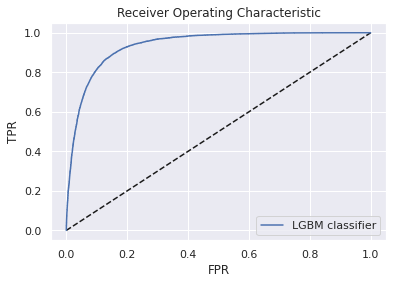

In [21]:
#ROC Curve
from sklearn.metrics import roc_curve
y_pred_prob1 = model.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)

# y_pred_prob2 = classifier2.predict_proba(X_test)[:,1]
# fpr2 , tpr2, thresholds2 = roc_curve(Y_test, y_pred_prob2)


# y_pred_prob3 = classifier3.predict_proba(X_test)[:,1]
# fpr3 , tpr3, thresholds3 = roc_curve(Y_test, y_pred_prob3)

# y_pred_prob4 = classifier4.predict_proba(X_test)[:,1]
# fpr4 , tpr4, thresholds4 = roc_curve(Y_test, y_pred_prob4)


plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "LGBM classifier")
# plt.plot(fpr2, tpr2, label= "Poly")
# plt.plot(fpr3, tpr3, label= "RBF")
# plt.plot(fpr4, tpr4, label= "Sigmoid")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

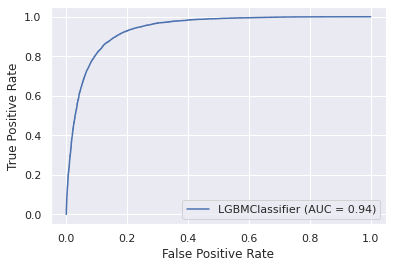

In [22]:
from sklearn.metrics import plot_roc_curve

classifiers = [model]
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, X_test, y_test, ax=ax)

In [ ]:
pred = model.predict_proba(predict, num_iteration=model.best_iteration_)[:,1]
test[TARGET_COL] = pred
test[["encounter_id","diabetes_mellitus"]].to_csv("submission.csv",index=False)